In [1]:
import timeit
import pandas as pd
import seaborn as sns
import graspologic
from graspologic.simulations import er_np
from graspologic.plot import heatmap
from graspologic.utils import utils as gus
import networkx as nx
from scipy.sparse import csr_matrix, isspmatrix_csr
from scipy.sparse.csgraph import connected_components

import matplotlib.pyplot as plt
import numpy as np

Time it takes to do conversion<br /> 
Time it takes to do check <br />
Start with networkx and scipy graphs (same graph)<br />
One plot showing conversion time vs number of vertices<br />
One plot showing check time vs num vertices<br />
Don’t care about small graphs - do bigger graphs<br />
Don’t need to increase by 50<br />
N-verts scale: 100, 1000, 10000, etc (log scale)<br />
Use ER graph with prob p=0.05, make fairly small<br />
Use pandas dataframe

# Plan for simulation

n_verts = [100, 1000, 10000, 100000]

## Part 1: Plotting times for conversions

1. Create local function that converts an nx graph to scipy sparse matrix
2. Record times it takes for function to run on nx erdos renyi graph per n_vert
3. Create local function that converts a csr_matrix to nx graph
4. Record times it takes for function to run on csr_matrix per n_vert
5. Plot time vs n_verts for the 2 datasets

## Part 2: Plotting time for LCC check
1. Create local function that uses scipy connected_components method on scipy sparse matrix
2. Record times it takes for function to run on scipy sparse matrix per n_vert
3. Create local function that uses nx is_connected method on nx graph
4. Record times it takes for function to run on nx erdos renyi graph per n_vert
5. Plot time vs n_verts for the 2 datasets

## Part 3: Cumulative Plot of nx vs scipy
1. First dataset: LCC check scipy graph with scipy connected_components (no conversion)
2. Second dataset: LCC check nx erdos renyi graph with nx is_connected method (no conversion)
3. Third dataset: Convert nx graph to scipy sparse and then LCC check with scipy connected_components 
4. Fourth dataset: Convert scipy csr_matrix to nx graph and then LCC check with nx is_connected method
5. Plot time vs n_verts of 4 datasets

## Part 4: Function on np.ndarray
1. Create local function that uses scipy connected_components method on np.ndarray
2. Record times it takes for function to run on ndarray per n_vert
3. Create local function that uses nx is_connected method on np.ndarray
4. Record times it takes for function to run on ndarray per n_vert
5. Plot time vs n_verts of 2 datasets

# Simulation 1: Conversion times

In [2]:
N = [10, 100, 1000, 10000]
n_verts = []
time_conv_to_nx = []
time_conv_to_scipy = []

In [3]:
def conv_scipy_to_nx(csr_graph):
    start_time = timeit.default_timer()
    
    if isinstance(csr_graph, (np.ndarray, csr_matrix)):
        if gus.is_symmetric(csr_graph):
            g_object = nx.Graph()
        else:
            g_object = nx.DiGraph()
        nx_graph = nx.to_networkx_graph(csr_graph, create_using=g_object)
    
    elapsed_orig = timeit.default_timer() - start_time
    return elapsed_orig

    time_conv_to_nx.append(elapsed_orig)

In [4]:
def conv_nx_to_scipy(nx_graph):
    start_time = timeit.default_timer()
    
    if not (isspmatrix_csr(nx_graph) or isinstance(nx_graph, np.ndarray)):
        scipy_graph = nx.to_scipy_sparse_matrix(nx_graph)
    if gus.is_symmetric(scipy_graph):
        directed = True
    else:
        directed = False
    
    elapsed_scipy = timeit.default_timer() - start_time
    return elapsed_scipy

    time_conv_to_scipy.append(elapsed_scipy)

In [5]:
#test for generating csr_matrix with probability 0.05
A = np.random.rand(10)
print(A)
#0.05 chance that element is 1, else 0
A = [abs((int)(x+0.95)-1) for x in A]
A = np.array(A).reshape(2, 5)
print(A)
A = csr_matrix(A)
print(A)

[0.78238116 0.71631085 0.30263582 0.26659936 0.59812077 0.31360463
 0.70660638 0.29872115 0.9181926  0.33356689]
[[0 0 0 0 0]
 [0 0 0 0 0]]



In [6]:
for n in N:
    for _ in range(30):
        n_verts.append(n)
        
        A = np.random.rand(n * n)
        A = [abs((int)(x+0.95)-1) for x in A]
        A = np.array(A).reshape(n, n)
        A = csr_matrix(A)
        elapsed_nx = conv_scipy_to_nx(A)
        time_conv_to_nx.append(elapsed_nx)
        
        B = nx.erdos_renyi_graph(n, 0.05)
        elapsed_scipy = conv_nx_to_scipy(B)
        time_conv_to_scipy.append(elapsed_scipy)

In [7]:
time_orig_conv_dict = {"time_conv_orig": time_conv_to_nx, "n_verts": n_verts}
df_conv_orig = pd.DataFrame(data = time_orig_conv_dict)

In [8]:
time_scipy_conv_dict = {"time_conv_scipy": time_conv_to_nx, "n_verts": n_verts}
df_conv_scipy = pd.DataFrame(data = time_scipy_conv_dict)

Text(0.5, 1.0, 'Times for conversion vs n_verts')

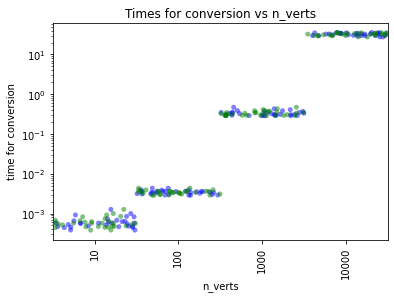

In [9]:
ax1 = sns.stripplot(data=df_conv_orig,
    x="n_verts",
    y="time_conv_orig",
    jitter = 0.5,
    alpha = 0.5,
    size=5,
    color='blue'
)

ax2 = sns.stripplot(data=df_conv_scipy,
    x="n_verts",
    y="time_conv_scipy",
    jitter = 0.5,
    alpha = 0.5,
    size=5,
    color= 'green'
)
ax1.set_yscale('log')
plt.xticks(rotation='vertical')
plt.xlabel('n_verts')
plt.ylabel('time for conversion')
plt.title("Times for conversion vs n_verts")

# Simulation 2: LCC Check Times

In [10]:
def orig_LCC_check(nx_graph):
    if type(nx_graph) in [nx.Graph, nx.MultiGraph]:
        return nx.is_connected(nx_graph)
    elif type(graph) in [nx.DiGraph, nx.MultiDiGraph]:
        return nx.is_weakly_connected(nx_graph)

In [11]:
def scipy_LCC_check(scipy_graph):
    
    n_components, labels = connected_components(
        csgraph=scipy_graph, directed=False, connection="weak", return_labels=True
    )

    return n_components == 1

In [12]:
n_verts = []
time_orig_LCC_check = []
time_scipy_LCC_check = []

In [13]:
for n in N:
    for _ in range(30):
        n_verts.append(n)
        
        B = nx.erdos_renyi_graph(n, 0.05)
        start_time = timeit.default_timer()
        val1 = orig_LCC_check(B)
        elapsed_orig = timeit.default_timer() - start_time
        time_orig_LCC_check.append(elapsed_orig)
        
        A = np.random.rand(n * n)
        A = [abs((int)(x+0.95)-1) for x in A]
        A = np.array(A).reshape(n, n)
        A = csr_matrix(A)
        start_time = timeit.default_timer()
        val2 = scipy_LCC_check(A)
        elapsed_scipy = timeit.default_timer() - start_time
        time_scipy_LCC_check.append(elapsed_scipy)

In [14]:
time_orig_LCC_dict = {"time_orig_check": time_orig_LCC_check, "n_verts": n_verts}
df_check_orig = pd.DataFrame(data = time_orig_LCC_dict)

In [15]:
time_scipy_LCC_dict = {"time_scipy_check": time_scipy_LCC_check, "n_verts": n_verts}
df_check_scipy = pd.DataFrame(data = time_scipy_LCC_dict)

Text(0.5, 1.0, 'Times for LCC check vs n_verts')

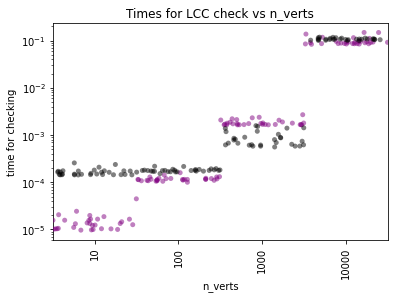

In [16]:
ax1 = sns.stripplot(data=df_check_orig,
    x="n_verts",
    y="time_orig_check",
    jitter = 0.5,
    alpha = 0.5,
    size=5,
    color='purple'
)

ax2 = sns.stripplot(data=df_check_scipy,
    x="n_verts",
    y="time_scipy_check",
    jitter = 0.5,
    alpha = 0.5,
    size=5,
    color='black'
)
ax1.set_yscale('log')
plt.xticks(rotation='vertical')
plt.xlabel('n_verts')
plt.ylabel('time for checking')
plt.title("Times for LCC check vs n_verts")

# Simulation 3: Different settings of LCC

In [17]:
n_verts = []

times_nx_nx = []
times_scipy_nx = []

times_nx_scipy = []
times_scipy_scipy = []

In [18]:
for n in N:
    for _ in range(30):
        
        n_verts.append(n)
        
        A = np.random.rand(n * n)
        A = [abs((int)(x+0.95)-1) for x in A]
        A = np.array(A).reshape(n, n)
        A = csr_matrix(A)
        B = nx.erdos_renyi_graph(n, 0.05)
        
        #nx graph, is_fully_connected
        start_time = timeit.default_timer()
        C = gus.is_fully_connected(B)
        elapsed_nx_nx = timeit.default_timer() - start_time
        times_nx_nx.append(elapsed_nx_nx)
        
        #scipy graph, is fully_connected
        start_time = timeit.default_timer()
        D = gus.is_fully_connected(A)
        elapsed_scipy_nx = timeit.default_timer() - start_time
        times_scipy_nx.append(elapsed_scipy_nx) 
        
        #nx graph, scipy_is_fully_connected
        start_time = timeit.default_timer()
        E = gus.scipy_is_fully_connected(B)
        elapsed_nx_scipy = timeit.default_timer() - start_time
        times_nx_scipy.append(elapsed_nx_scipy)
        
        #scipy graph, scipy_is_fully_connected
        start_time = timeit.default_timer()
        F = gus.scipy_is_fully_connected(A)
        elapsed_scipy_scipy = timeit.default_timer() - start_time
        times_scipy_scipy.append(elapsed_scipy_scipy)

In [19]:
nx_nx_dict = {"nx_nx": times_nx_nx, "n_verts": n_verts}
df_nx_nx = pd.DataFrame(data = nx_nx_dict)

In [20]:
scipy_nx_dict = {"scipy_nx": times_scipy_nx, "n_verts": n_verts}
df_scipy_nx = pd.DataFrame(data = scipy_nx_dict)

In [21]:
nx_scipy_dict = {"nx_scipy": times_nx_scipy, "n_verts": n_verts}
df_nx_scipy = pd.DataFrame(data = nx_scipy_dict)

In [22]:
scipy_scipy_dict = {"scipy_scipy": times_scipy_scipy, "n_verts": n_verts}
df_scipy_scipy = pd.DataFrame(data = scipy_scipy_dict)

Text(0.5, 1.0, 'Times for original vs new is_fully_connected on nx/scipy graphs')

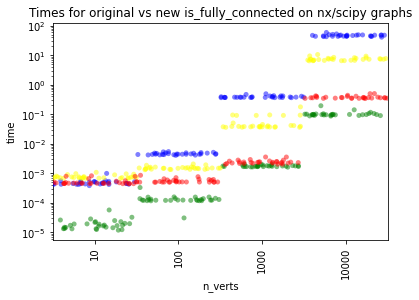

In [23]:
ax1 = sns.stripplot(data=df_nx_nx,
    x="n_verts",
    y="nx_nx",
    jitter = 0.5,
    alpha = 0.5,
    size=5,
    color='green'
)

ax2 = sns.stripplot(data=df_scipy_nx,
    x="n_verts",
    y="scipy_nx",
    jitter = 0.5,
    alpha = 0.5,
    size=5,
    color='blue'
)

ax3 = sns.stripplot(data=df_nx_scipy,
    x="n_verts",
    y="nx_scipy",
    jitter = 0.5,
    alpha = 0.5,
    size=5,
    color='yellow'
)

ax4 = sns.stripplot(data=df_scipy_scipy,
    x="n_verts",
    y="scipy_scipy",
    jitter = 0.5,
    alpha = 0.5,
    size=5,
    color='red'
)
ax1.set_yscale('log')
plt.xticks(rotation='vertical')
plt.ylabel('time')
plt.title("Times for original vs new is_fully_connected on nx/scipy graphs")

# Simulation 4: np.ndarray comparison

In [24]:
n_verts = []

times_nx = []
times_scipy = []

In [25]:
for n in N:
    for _ in range(30):
        
        n_verts.append(n)
        
        A = np.random.rand(n * n)
        A = [abs((int)(x+0.95)-1) for x in A]
        A = np.array(A).reshape(n, n)
        
        start_time = timeit.default_timer()
        C = gus.is_fully_connected(A)
        elapsed_nx = timeit.default_timer() - start_time
        times_nx.append(elapsed_nx)
        
        start_time = timeit.default_timer()
        E = gus.scipy_is_fully_connected(A)
        elapsed_scipy = timeit.default_timer() - start_time
        times_scipy.append(elapsed_scipy)

In [26]:
nx_dict = {"nx": times_nx, "n_verts": n_verts}
df_nx = pd.DataFrame(data = nx_dict)

In [27]:
scipy_dict = {"scipy": times_scipy, "n_verts": n_verts}
df_scipy = pd.DataFrame(data = scipy_dict)

Text(0.5, 1.0, 'Times for original vs new is_fully_connected on np.ndarray')

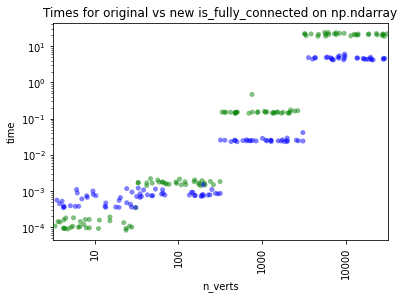

In [28]:
ax1 = sns.stripplot(data=df_nx,
    x="n_verts",
    y="nx",
    jitter = 0.5,
    alpha = 0.5,
    size=5,
    color='green'
)

ax2 = sns.stripplot(data=df_scipy,
    x="n_verts",
    y="scipy",
    jitter = 0.5,
    alpha = 0.5,
    size=5,
    color='blue'
)

ax1.set_yscale('log')
plt.xticks(rotation='vertical')
plt.ylabel('time')
plt.title("Times for original vs new is_fully_connected on np.ndarray")